In [1]:
# goal: reproduce figure 5 from dean's artiphysiology paper
import numpy as np
import torch
import matplotlib.pyplot as plt
import xarray as xr
from torchvision import datasets, models, transforms
from scipy.stats import kurtosis
from util.net_response_functions import *

# params
layer_name = "conv11"

In [2]:
# import apc fits
apc_fits = np.load(f"./data/apc_fit/vgg16_{layer_name}_apc_fits.npy",
                  allow_pickle=True)

# import apc models
apc_models = xr.open_dataset("./data/apc_fit/apc_models_362_16x16.nc")

# import actual responses
outputs_tt = torch.load(f"./data/net_responses/vgg16_{layer_name}_output.pt")

In [32]:
# want n units with highest correlation that pass kurtosis filter
def get_n_most_selective_units(n, apc_fits, apc_models, outputs_tt):
    
    # apply kurtosis filter
    # unit_responses[stim][unit]
    unit_responses = get_unit_responses(outputs_tt)
    unit_kurtosis = kurtosis(unit_responses, axis=0)    
    k_filtered_i, = np.where((unit_kurtosis >= 2.9) & (unit_kurtosis <= 42))
    
    # get most selective units from those that pass kurtosis filter
    k_filtered_fits = apc_fits[k_filtered_i]
    sorted_fits = np.argsort(k_filtered_fits[:,2])
    sorted_fits = k_filtered_fits[sorted_fits]
    
    return sorted_fits[::-1][:n]
    
selective_units = get_n_most_selective_units(10, apc_fits, apc_models, outputs_tt)
print(selective_units)

[[1.39000000e+02 5.74700000e+03 6.87551923e-01]
 [4.39000000e+02 1.38890000e+04 6.76177903e-01]
 [5.60000000e+01 5.69600000e+03 6.60352407e-01]
 [9.90000000e+01 1.76500000e+03 6.11570793e-01]
 [1.59000000e+02 9.97400000e+03 6.00766631e-01]
 [1.33000000e+02 9.21800000e+03 5.96581629e-01]
 [4.38000000e+02 1.40720000e+04 5.92978411e-01]
 [3.24000000e+02 1.79240000e+04 5.77448788e-01]
 [1.01000000e+02 1.34880000e+04 5.61321223e-01]
 [1.88000000e+02 2.62240000e+04 5.55519181e-01]]


13889.0


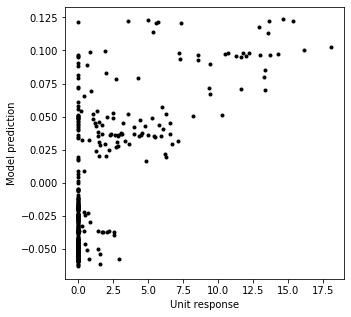

In [34]:
# apc_fits = [(unit, best_model_idx, best_corr)]
def plot_apc_fits_for_unit(unit, apc_fits, apc_models, outputs_tt):
    
    # get x data (actual unit responses across stim)
    unit_responses = get_unit_responses(outputs_tt, unit)
    
    # get y data (predicted responses from unit's best fit model)
    (_, i_model, best_corr) = apc_fits[unit]
    model_responses = apc_models.resp[:, int(i_model)]
    print(i_model)
    
    # plot 'em
    fig, axes = plt.subplots(1, figsize=(5, 5))
    axes.set_xlabel("Unit response")
    axes.set_ylabel("Model prediction")
    
    axes.plot(unit_responses, model_responses, "k.")

plot_apc_fits_for_unit(439, apc_fits, apc_models, outputs_tt)

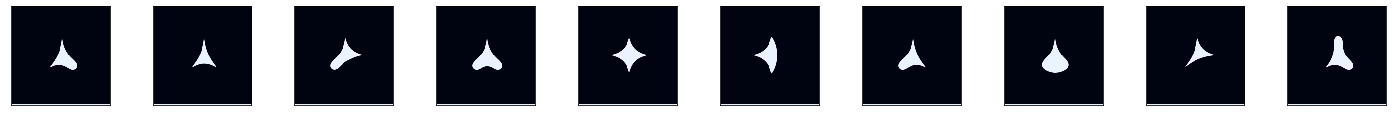

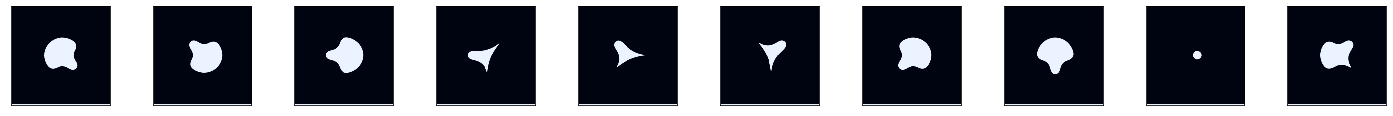

In [37]:
# pull in images
img_xy = 200
data_transforms = transforms.Compose([
    transforms.CenterCrop(img_xy),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(
    root="./data/stimuli",
    transform=data_transforms)

image_loader = torch.utils.data.DataLoader(image_dataset)

# function to denormalize and display an image
def imshow(img):
    img = (img - img.min())/(img - img.min()).max()
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

def show_images(imgs, idxs):
    # plot images idxs from the given ImageFolder
    fig = plt.figure(figsize=(25, 4))

    fig_i = 0
    for i in idxs:
        img, label = imgs[i]
        img = img.numpy()
        ax = fig.add_subplot(2, 20/2, fig_i+1, xticks=[], yticks=[])
        imshow(img)
        fig_i += 1

def display_top_and_bottom(unit, n, outputs_tt):
    # for a given unit, display the top/bottom n stimuli ranked by response activation

    # get all responses for given unit
    spatial_idx = int((len(outputs_tt[0, 0, 0]) - 1) / 2)
    unit_outputs = outputs_tt[:, 0, unit, spatial_idx, spatial_idx]

    # get indices top/bottom n stimuli
    top_n = torch.topk(unit_outputs, k=n)
    bot_n = torch.topk(unit_outputs, k=n, largest=False)

    top_n_idx = top_n.indices
    bot_n_idx = bot_n.indices

    # display those stimuli
    show_images(image_dataset, top_n_idx)
    show_images(image_dataset, bot_n_idx)

    return unit_outputs

# call function
result = display_top_and_bottom(unit=439, n=10, outputs_tt=outputs_tt)

In [ ]:
def plot_motif_dynamics(w_mon, synapses, N, use_p0=True, save_fig=False):
    """
    Plot motif dynamics a la figure 7 from Ocker et al 2015
    Args:
        w_mon (StateMonitor): Brian2 synaptic weight monitor
        synapses (Synapses): Brian2 synapses in network
        N (int): number of neurons
        save_fig (bool): optional flag to output figure image
    """
    motif_names = ["p", "q_div", "q_con", "q_ch", "q_rec"]
    motif_stats_mat = get_motif_stats_in_time(w_mon, synapses, N, use_p0=use_p0)

    fig, axes = plt.subplots(5, figsize=(5, 10))

    plt.xlabel("Time (s)")
    fig.suptitle("Motif dynamics: N=" + str(N))
    for i in range(5):
        ax = axes[i]
        ax.plot(w_mon.t, motif_stats_mat[:, i])
        ax.set_ylabel(motif_names[i])

    if not save_fig:
        return

    now = str(time.time())
    name = "results/motifs_N=" + str(N) + "_t=" + str(w_mon.t[-1]) + "_" + now + ".png"
    plt.savefig(name, dpi=300, bbox_inches='tight')